# Dimensionality reduction with t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the [visualization of high-dimensional datasets](https://lvdmaaten.github.io/tsne/). It was created by [van der Maaten and Hinton](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf) in 2008. 

In this notebooks, we are going to show how t-SNE works using features extracted from the kaggle dataset [dogs vs cats](https://www.kaggle.com/c/dogs-vs-cats/). For extracting the features, we will use ResNet50 as featurizer. 

We present and compare two implementations of t-SNE: [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), implemented in python and [CUDA](https://github.com/georgedimitriadis/t_sne_bhcuda), implemented by George Dimitriadis in CUDA/C++ with python wrappers.


In [1]:
import os
import sys
import numpy as np
import sklearn
import keras as K
from keras.applications.nasnet import NASNetLarge
from keras.applications.resnet50 import ResNet50
import tensorflow as tf
import kaggle
from numba import cuda
import t_sne_bhcuda.t_sne_bhcuda.bhtsne_cuda as tsne_bhcuda
from utils import (plot_tsne, get_gpu_name, get_cuda_version, get_cudnn_version,
                   find_files_with_pattern, featurize_images, clear_memory_all_gpus)

print("System version: {}".format(sys.version))
print("Sklearn version: {}".format(sklearn.__version__))
print("Numpy version: {}".format(np.__version__))
print("Kaggle version: {}".format(kaggle.KaggleApi.__version__))
print("Keras version: {}".format(K.__version__))
print("Keras backend: {}".format(K.backend.backend()))
print("Keras image data format: {}".format(K.backend.image_data_format()))
print("Tensorflow version: {}".format(tf.__version__))
print("GPU: {}".format(get_gpu_name()))
print("CUDA version: {}".format(get_cuda_version()))
print("CuDNN version: {}".format(get_cudnn_version()))


# Autoreload changes in imported files
%load_ext autoreload
%autoreload 2

# Allow multiple displays per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


System version: 3.5.5 |Anaconda custom (64-bit)| (default, May 13 2018, 21:12:35) 
[GCC 7.2.0]
Sklearn version: 0.19.1
Numpy version: 1.14.5
Kaggle version: 1.5.0
Keras version: 2.2.2
Keras backend: tensorflow
Keras image data format: channels_last
Tensorflow version: 1.10.1
GPU: ['Tesla K80']
CUDA version: CUDA Version 9.2.148
CuDNN version: 7.2.1


### Dataset

For testing the algorithm we are going to use the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset, which contains 2 classes and 25000 images.

Kaggle has a nice [api](https://github.com/Kaggle/kaggle-api) that allows one to programmatically work with their content. We can use their client to download the dataset. Make sure you follow the [instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to get the Kaggle credentials. 


In [2]:
!/anaconda/envs/py35/bin/kaggle competitions download -c dogs-vs-cats --force

  0%|                                               | 0.00/86.8k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 86.8k/86.8k [00:00<00:00, 1.11MB/s]
 95%|█████████████████████████████████████▉  | 257M/271M [00:04<00:00, 34.0MB/s]
100%|████████████████████████████████████████| 271M/271M [00:05<00:00, 54.4MB/s]
 98%|███████████████████████████████████████▍| 535M/543M [00:07<00:00, 70.3MB/s]
100%|████████████████████████████████████████| 543M/543M [00:12<00:00, 45.9MB/s]


In [3]:
!unzip -q train.zip

Let's take a look at the data

In [4]:
files_dog = find_files_with_pattern("train", "dog*")
len(files_dog)
print(files_dog[:10])

files_cat = find_files_with_pattern("train", "cat*")
len(files_cat)
print(files_cat[:10])

12500

['train/dog.7647.jpg', 'train/dog.4124.jpg', 'train/dog.11342.jpg', 'train/dog.7021.jpg', 'train/dog.7305.jpg', 'train/dog.1757.jpg', 'train/dog.1804.jpg', 'train/dog.8312.jpg', 'train/dog.2823.jpg', 'train/dog.1423.jpg']


12500

['train/cat.6586.jpg', 'train/cat.11278.jpg', 'train/cat.8459.jpg', 'train/cat.1983.jpg', 'train/cat.5735.jpg', 'train/cat.3765.jpg', 'train/cat.10067.jpg', 'train/cat.6049.jpg', 'train/cat.783.jpg', 'train/cat.8995.jpg']


Now we are going to subsample part of the data, we don't need all the data for our experiments.

In [5]:
sample = 5000
files_dog = files_dog[:sample]
files_cat = files_cat[:sample]
file_names = files_dog + files_cat
len(file_names)

10000

In [6]:
labels_dog = [0]*len(files_dog)
labels_cat = [1]*len(files_cat)
labels = labels_dog + labels_cat
len(labels)

10000

### Image featurization

CNNs are great featurizers, many times used in [transfer learning](https://miguelgfierro.com/blog/2017/a-gentle-introduction-to-transfer-learning-for-image-classification/). 

![ResNet CNN](https://cdn.rawgit.com/miguelgfierro/sciblog_support/master/A_Gentle_Introduction_to_Transfer_Learning/img/resnet.svg)

The standard strategy is to remove the last layer of the CNN to featurize the input images. In our example, we will use [ResNet](https://arxiv.org/abs/1512.03385), pretrained on [ImageNet dataset](http://image-net.org/), with 50 layers. For this case, the input image is a matrix of `224x224x3` (height, weigth, color channels), and the output is a vector of 2048 floats, corresponding to the number of units of the penultimate layer. This vector is a very good low level representation of the original image.

In [7]:
#https://keras.io/applications/#resnet50
model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='avg')

In [8]:
features = featurize_images(file_names, model)
features.shape

157it [01:50,  1.54it/s]


(10000, 2048)

In [9]:
# clear gpu memory
del model
clear_memory_all_gpus()

### Dimensionality reduction with t-SNE

t-Distributed Stochastic Neighbor Embedding ([t-SNE](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf)) algorithm, and its [faster implementation](https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf) are designed for visualization of high-dimensional data in scatter plots. t-SNE is an improvement over [SNE](http://papers.nips.cc/paper/2276-stochastic-neighbor-embedding.pdf) developed years later by Hinton et al. 

t-SNE reduces the dimensionality of a high-dimensional dataset $X={x_1, x_2, ..., x_n}$ to a two or three dimensional dataset $Y={y_1, y_2, ..., y_n}$, by modeling the high-dimensional Euclidean distances between datapoints as joint probabilities $p_{ij}$ that represent similarities. For nearby data points, $p_{ij}$ is relatively high, and for separated points, $p_{ij}$ is low. The joint probability is computed based on the conditional probability $p_{j/i}$, which is as a Gaussian centered in $x_i$, and defined as $p_{ij} = (p_{j/i} + p_{i/j})/2n$, where 

$$ p_{j/i} = \frac{exp( - \lVert x_i - x_j \rVert^2/2\sigma_i^2)}{\sum_{k\ne i} exp( - \lVert x_i - x_k \rVert^2/2\sigma_i^2) )}$$


For the low-dimensional space, the authors use [Student t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) with one degree of freedom to convert pairwise distances into probabilities. 

$$ q_{ij} = \frac{ ( 1 + \lVert y_i - y_j \rVert^2 )^{-1} }{\sum_{k\ne l} ( 1 + \lVert y_i - y_j \rVert^2 )^{-1} )}$$

Here, the $y$ in the $q_{ij}$ are the learned parameters, i.e. the low dimensional space. Student t-distribution has a several nice properties that makes it preferable over the Gaussian. 

First, it addresses the *crowded problem*, which is explained by the authors as "in ten dimensions, it is possible to have 11 datapoints that are mutually equidistant and there is no way to model this faithfully in a two-dimensional map". Student t-distribution is a heavy-tailed distribution, and therefore it is almost invariant to changes in the scale of points that are far apart. This effectively means that when mapping pairwise distances from the high-dimensional space to the low-dimensional space, the scale between points is roughly maintained. 

Second, the t-distribution is computationally faster to evaluate in comparison with the Gaussian, since it doesn't involve an exponential. 

The final step in the algorithm is to minimize the mismatch between $p_{ij}$ and $q_{ij}$. For that task, the authors use the [Kullback-Liebler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence):

$$ \min KL(P\lVert Q) = \min \sum_i \sum_j p_{ij}\log\frac{p_{ij}}{q_{ij}} $$

To optimize this cost function, a gradient descent method can be used. The gradient is:

$$ \frac{\delta C}{\delta y_i} = 4 \sum_j (p_{ij} - q_{ij})(y_i - y_j)( 1 + \lVert y_i - y_j \rVert^2 )^{-1} $$

Under some circustances, t-SNE can generate clusters, as some authors have proved [here](https://arxiv.org/abs/1706.02582) and [here](https://arxiv.org/abs/1803.01768). However, this is [not always the case](https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne/264647#264647), and such clusters can appear in non-clustered data.

### t-SNE implementation

Next, we compute t-SNE with the features obtained from the CNN, using two implementations: [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), and [CUDA](https://github.com/georgedimitriadis/t_sne_bhcuda).


In [10]:
perplexity = 10.0
theta = 0.5
learning_rate = 200.0
iterations = 2000
gpu_mem = 0.95
files_dir='tsne_results'

In [11]:
%%time
t_sne_result_sklearn = tsne_bhcuda.t_sne(samples=features, use_scikit=True, files_dir=files_dir,
                        no_dims=2, perplexity=perplexity, eta=learning_rate, theta=theta,
                        iterations=iterations, gpu_mem=gpu_mem, randseed=77, verbose=2)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.374s...
[t-SNE] Computed neighbors for 10000 samples in 386.236s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.098726
[t-SNE] Computed conditional probabilities in 0.780s
[t-SNE] Iteration 50: error = 28.9407291, gradient norm = 0.0125538 (50 iterations in 12.188s)
[t-SNE]

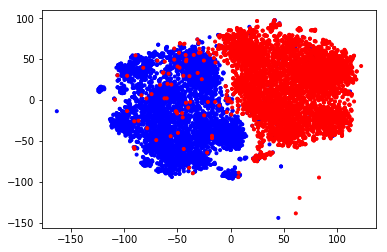

In [12]:
plot_tsne(t_sne_result_sklearn, labels)

In [13]:
%%time
t_sne_result_gpu = tsne_bhcuda.t_sne(samples=features, use_scikit=False, files_dir=files_dir,
                        no_dims=2, perplexity=perplexity, eta=learning_rate, theta=theta,
                        iterations=iterations, gpu_mem=gpu_mem, randseed=77, verbose=2)

Read the 10000 x 2048 data matrix successfully!
Using random seed: 77
Using no_dims = 2, perplexity = 10.000000, learning rate = 200.000000, and theta = 0.500000
Computing input similarities...

Device Name = Tesla K80
multiProcessorCount: 13
totalGlobalMem (in MB): 11441.187500
totalGlobalMem (in GB): 11.173035
sharedMemPerBlock (in bytes): 49152
Maximum number of threads per block: 1024
Maximum size of each dimension of a block: 1024 x 1024 x 64
Maximum sizes of each dimension of a grid: 2147483647 x 65535 x 65535
Compute capability of the device = 3.7
canMapHostMemory: TRUE
deviceOverlap: TRUE
GPU memory usage: used = 71.000000 MB, free = 11370.187500 MB, total = 11441.187500 MB

GPU iteration = 0, distance elements calculated = 100000000
GPU memory usage: used = 608.750000 MB, free = 10832.437500 MB, total = 11441.187500 MB
Time spent in calculating all distances in GPU: 6.535329
Building tree...
 - Building tree and finding perplexities, point 0 of 10000
Time spent building tree a

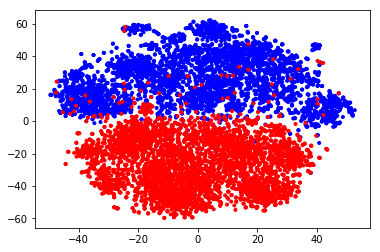

In [14]:
plot_tsne(t_sne_result_gpu, labels)

In [15]:
!rm -rf train

### Conclusion

Looking at the first plot from sklearn, we can see that the features are clustered into two groups, representing the dog and cat images. The second plot from CUDA, also shows two differentiated clusters, but in a different position copared to the first one. This might be due to differences in the optimization process and also because t-SNE models the datapoints as pairwise distances rather than absolute positions. Furthermore, since the algorithm isn’t deterministic, the problem might have multiple minima. As it can be expected, the C++ implementation is faster than the python one, but not by a high margin.

As a conclusion, t-SNE maps from a high-dimensional space to 2 or 3 low-dimensional space by modeling disimilar datapoints by large pairwise distances, and modeling similar datapoints by small pairwise distances. Furthermore, it's cost function is easier to optimize in comparison with other methods.

